In [1]:
import torch
print("cuda available:", torch.cuda.is_available())
print("device:", torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

cuda available: True
device: cuda


In [2]:
%pip install mlflow scikeras

In [3]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("cost-care")

2026/02/17 07:47:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/17 07:47:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/17 07:47:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/17 07:47:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/17 07:47:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/17 07:47:09 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/17 07:47:09 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/17 07:47:09 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='/content/mlruns/1', creation_time=1771312082463, experiment_id='1', last_update_time=1771312082463, lifecycle_stage='active', name='cost-care', tags={}>

In [4]:
# Print connection information
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Active Experiment: {mlflow.get_experiment_by_name('cost-care')}")

# Test logging
with mlflow.start_run():
    mlflow.log_param("test_param", "test_value")
    print("✓ Successfully connected to MLflow!")

MLflow Tracking URI: sqlite:///mlflow.db
Active Experiment: <Experiment: artifact_location='/content/mlruns/1', creation_time=1771312082463, experiment_id='1', last_update_time=1771312082463, lifecycle_stage='active', name='cost-care', tags={}>
✓ Successfully connected to MLflow!


In [5]:
!mlflow server --backend-store-uri sqlite:///mlflow.db --port 5000 > mlflow.log 2>&1 &

In [6]:
# dependecies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
import mlflow

PREPROCESSING/EDA

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# reading in the data
data = pd.read_csv('/content/drive/MyDrive/insurance_ml/cleaned_data.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category,charges_category,...,log_bmi,log_charges,northeast,northwest,southeast,southwest,female,male,no,yes
0,19,female,27.900,0,yes,southwest,16884.92400,18-25,Overweight,"$10,001-20,000",...,3.363842,9.734236,False,False,False,True,True,False,False,True
1,18,male,33.770,1,no,southeast,1725.55230,18-25,Obese,"$0-10,000",...,3.548755,7.453882,False,False,True,False,False,True,True,False
2,28,male,33.000,3,no,southeast,4449.46200,26-35,Obese,"$0-10,000",...,3.526361,8.400763,False,False,True,False,False,True,True,False
3,33,male,22.705,0,no,northwest,21984.47061,26-35,Normal,"$20,001-30,000",...,3.165686,9.998137,False,True,False,False,False,True,True,False
4,32,male,28.880,0,no,northwest,3866.85520,26-35,Overweight,"$0-10,000",...,3.397189,8.260455,False,True,False,False,False,True,True,False


In [9]:
# understanding categorical vs numerical (can also use df.dtypes)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int64  
 1   sex               1337 non-null   object 
 2   bmi               1337 non-null   float64
 3   children          1337 non-null   int64  
 4   smoker            1337 non-null   object 
 5   region            1337 non-null   object 
 6   charges           1337 non-null   float64
 7   age_category      1337 non-null   object 
 8   bmi_category      1337 non-null   object 
 9   charges_category  1337 non-null   object 
 10  elderly_smoker    1337 non-null   int64  
 11  obese_smoker      1337 non-null   int64  
 12  has_children      1337 non-null   int64  
 13  largeFamily       1337 non-null   int64  
 14  age_squared       1337 non-null   int64  
 15  log_bmi           1337 non-null   float64
 16  log_charges       1337 non-null   float64


In [10]:
# checking null values
data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0
age_category,0
bmi_category,0
charges_category,0


In [11]:
# checking duplicated values
data.duplicated().sum()

np.int64(0)

In [12]:
duplicated_rows = data[data.duplicated()]
duplicated_rows

,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category,charges_category,...,log_bmi,log_charges,northeast,northwest,southeast,southwest,female,male,no,yes


In [13]:
# handling duplicates
data = data.drop_duplicates()

In [14]:
data.shape

(1337, 25)

don't do label encoding which is assigning a number to each feature; it messes up a neural network; changing to one hot encoding which makes dummy variables for each feature (sql distinct comes in clutch here) and then uses binary

In [15]:
# ohe_region = pd.get_dummies(data.region)
# ohe_sex = pd.get_dummies(data.sex)
# ohe_smoker = pd.get_dummies(data.smoker)

ADVANCED FEATURE ENGINEERING

In [16]:
# # numerical => categorical for "imbalance"/skew purposes; THIS IS CALLED BINNING
# data['age_category'] = pd.cut(data['age'], bins=[0, 25, 35, 45, 55, 65], labels=['18-25', '26-35', '36-45', '46-55', '56-65'])
# data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
# data['charges_category'] = pd.cut(data['charges'], bins=[0, 10000, 20000, 30000, 40000, 50000, 60000, np.inf], labels=['$0-10,000', '$10,001-20,000', '$20,001-30,000', '$30,001-40,000', '$40,001-50,000', '$50,001-60,000', '$60,000+'])

In [17]:
# # focusing on smokers as correlation matrix indicated strong relationship
# data['elderly_smoker'] = ((data['smoker'] == 'yes') & (data['age'] > 39)).astype(int)
# data['obese_smoker'] = ((data['smoker'] == 'yes') & (data['bmi_category'] == 'Obese')).astype(int)

# # family size impact (testing)
# data['has_children'] = ((data['children'] > 0)).astype(int)
# data['largeFamily'] = ((data['children'] >= 3)).astype(int)

# # MORE
# data['age_squared'] = data['age'] ** 2
# data['log_bmi'] = np.log1p(data['bmi'])
# data['log_charges'] = np.log1p(data['charges'])

In [18]:
# data = pd.concat([data, ohe_region, ohe_sex, ohe_smoker], axis='columns')
# data.head()

In [19]:
# data.to_csv('cleaned_data.csv', index=False)

BEGINNING THE VISUALIZATIONS

In [20]:
# for all my plots
palette = ['#AF4B47', '#A75A48', '#EDDECB', '#9AAAAE', '#B5C3C4', '#E1C5AE', '#D1D9D7']
customCmap = ListedColormap(palette)

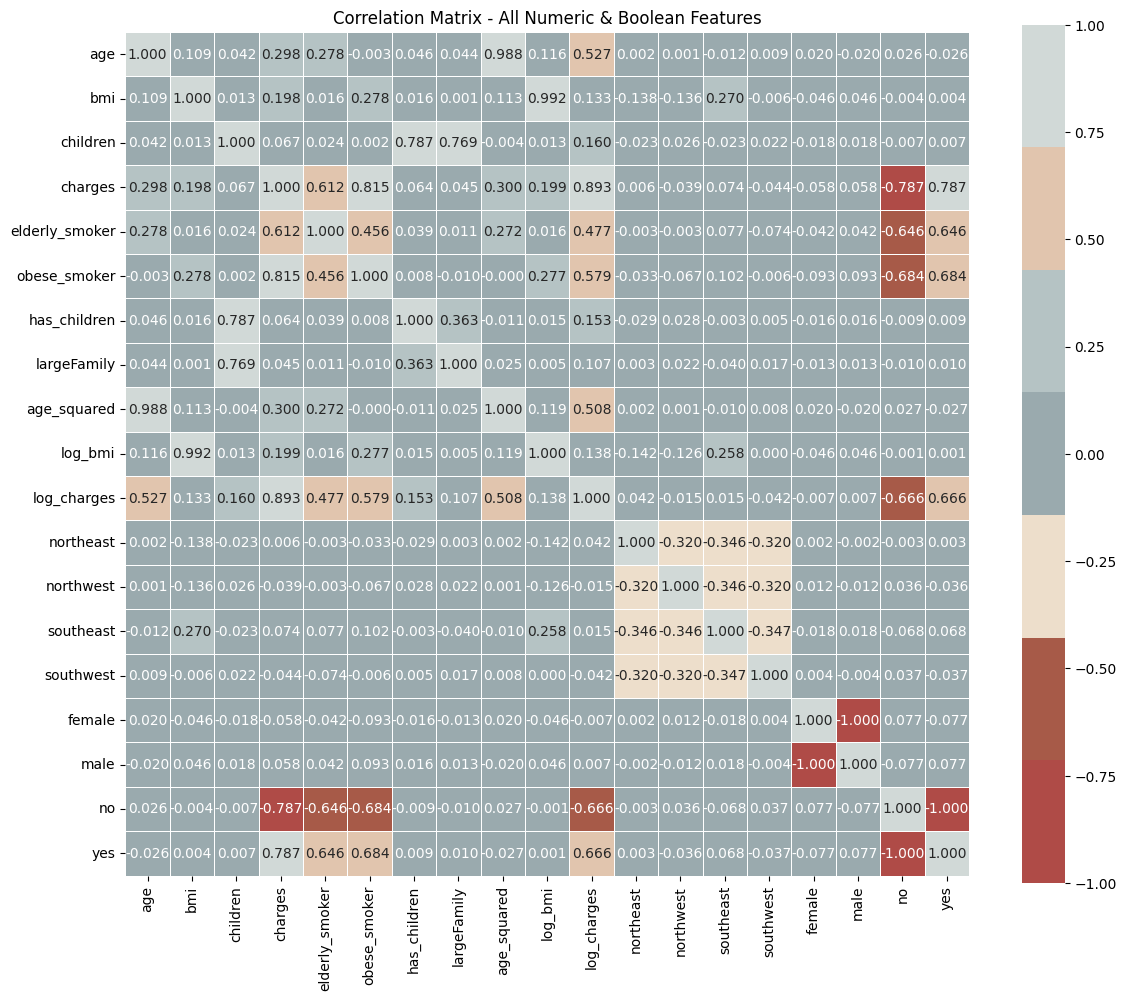


Correlations with Charges (target):
charges           1.000000
log_charges       0.893116
obese_smoker      0.815444
yes               0.787234
elderly_smoker    0.611675
age_squared       0.300166
age               0.298308
log_bmi           0.199455
bmi               0.198401
southeast         0.073578
children          0.067389
has_children      0.063985
male              0.058044
largeFamily       0.044930
northeast         0.005945
northwest        -0.038695
southwest        -0.043637
female           -0.058044
no               -0.787234
Name: charges, dtype: float64


In [21]:
# correlation matrix
correlation_matrix = data.select_dtypes(include=["number", "bool"]).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap=customCmap, 
            fmt='.3f', square=True, linewidths=0.5)
plt.title('Correlation Matrix - All Numeric & Boolean Features',)
plt.tight_layout()
plt.show()

print("\nCorrelations with Charges (target):")
print(correlation_matrix['charges'].sort_values(ascending=False))

strong correlation between smoking & insurance charges

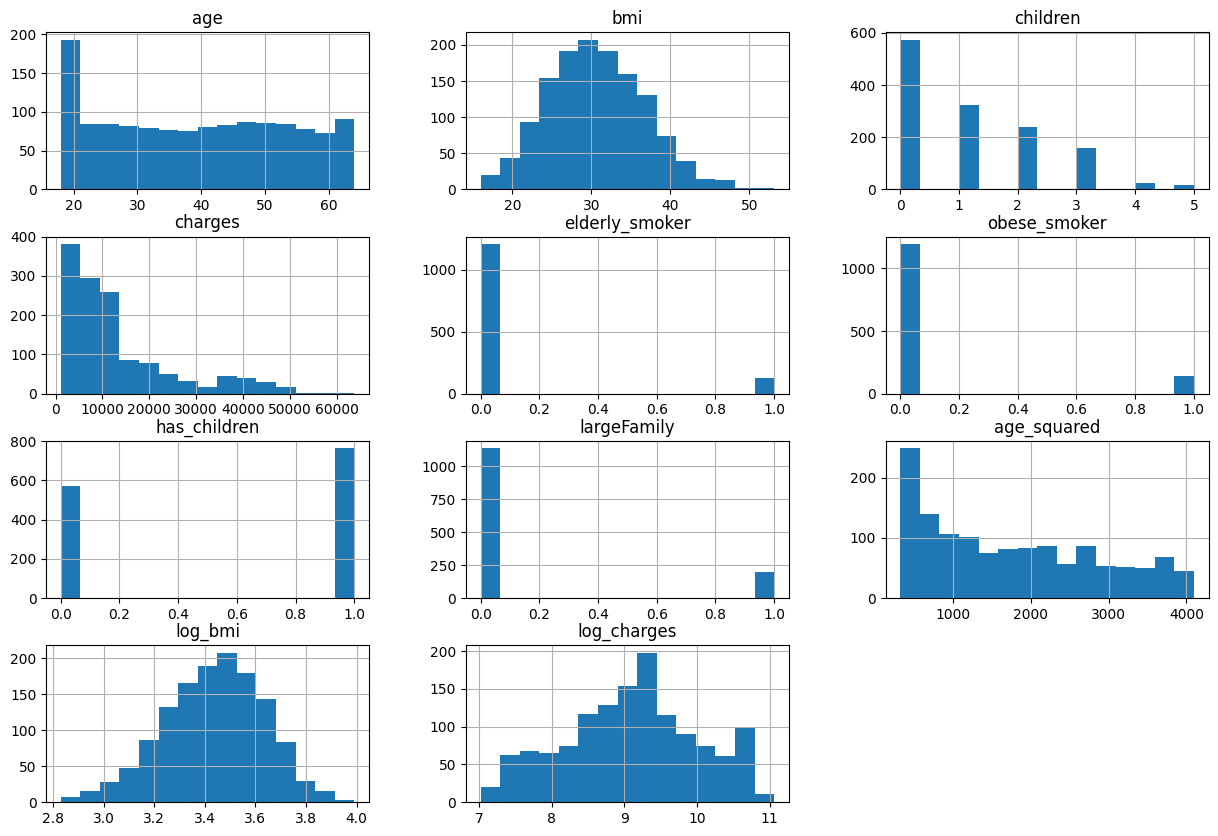

In [22]:
# histograms
histogram = data.select_dtypes(include=["number", "bool"]).hist(bins=15, figsize=[15,10])
plt.show()

<Axes: >

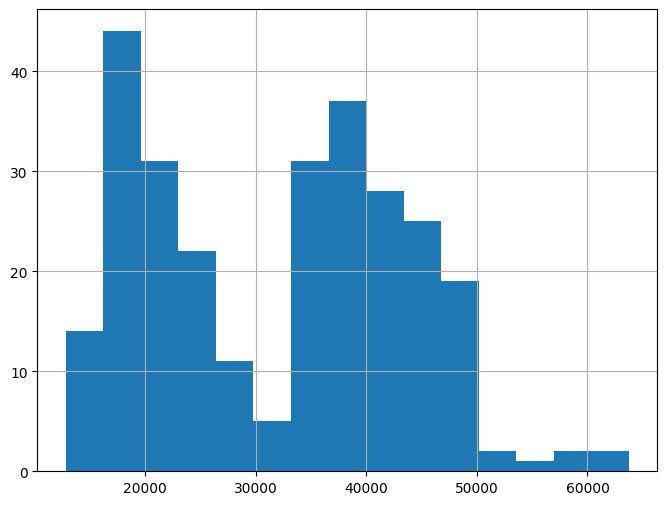

In [23]:
data[data['yes'] == True]['charges'].hist(bins=15, figsize=[8,6])

age, children, and charges are skewed to the right. bmi is reminscent of a normal curve. There is evidence of imbalance in age, children, and smoker features.

/tmp/ipython-input-3444421404.py:2: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(y='charges', x='region', hue='smoker', data=data, palette=palette)


<Axes: xlabel='region', ylabel='charges'>

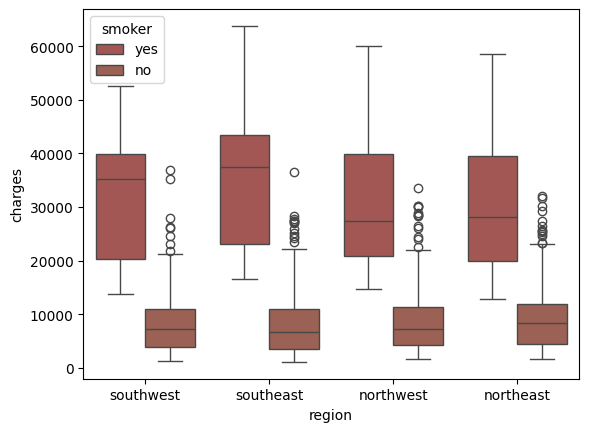

In [24]:
# due to charge feature skew, most outliers are on the higher end. 
sns.boxplot(y='charges', x='region', hue='smoker', data=data, palette=palette)

multiple experiments with boxplots; can make numerous conclusions about them. 

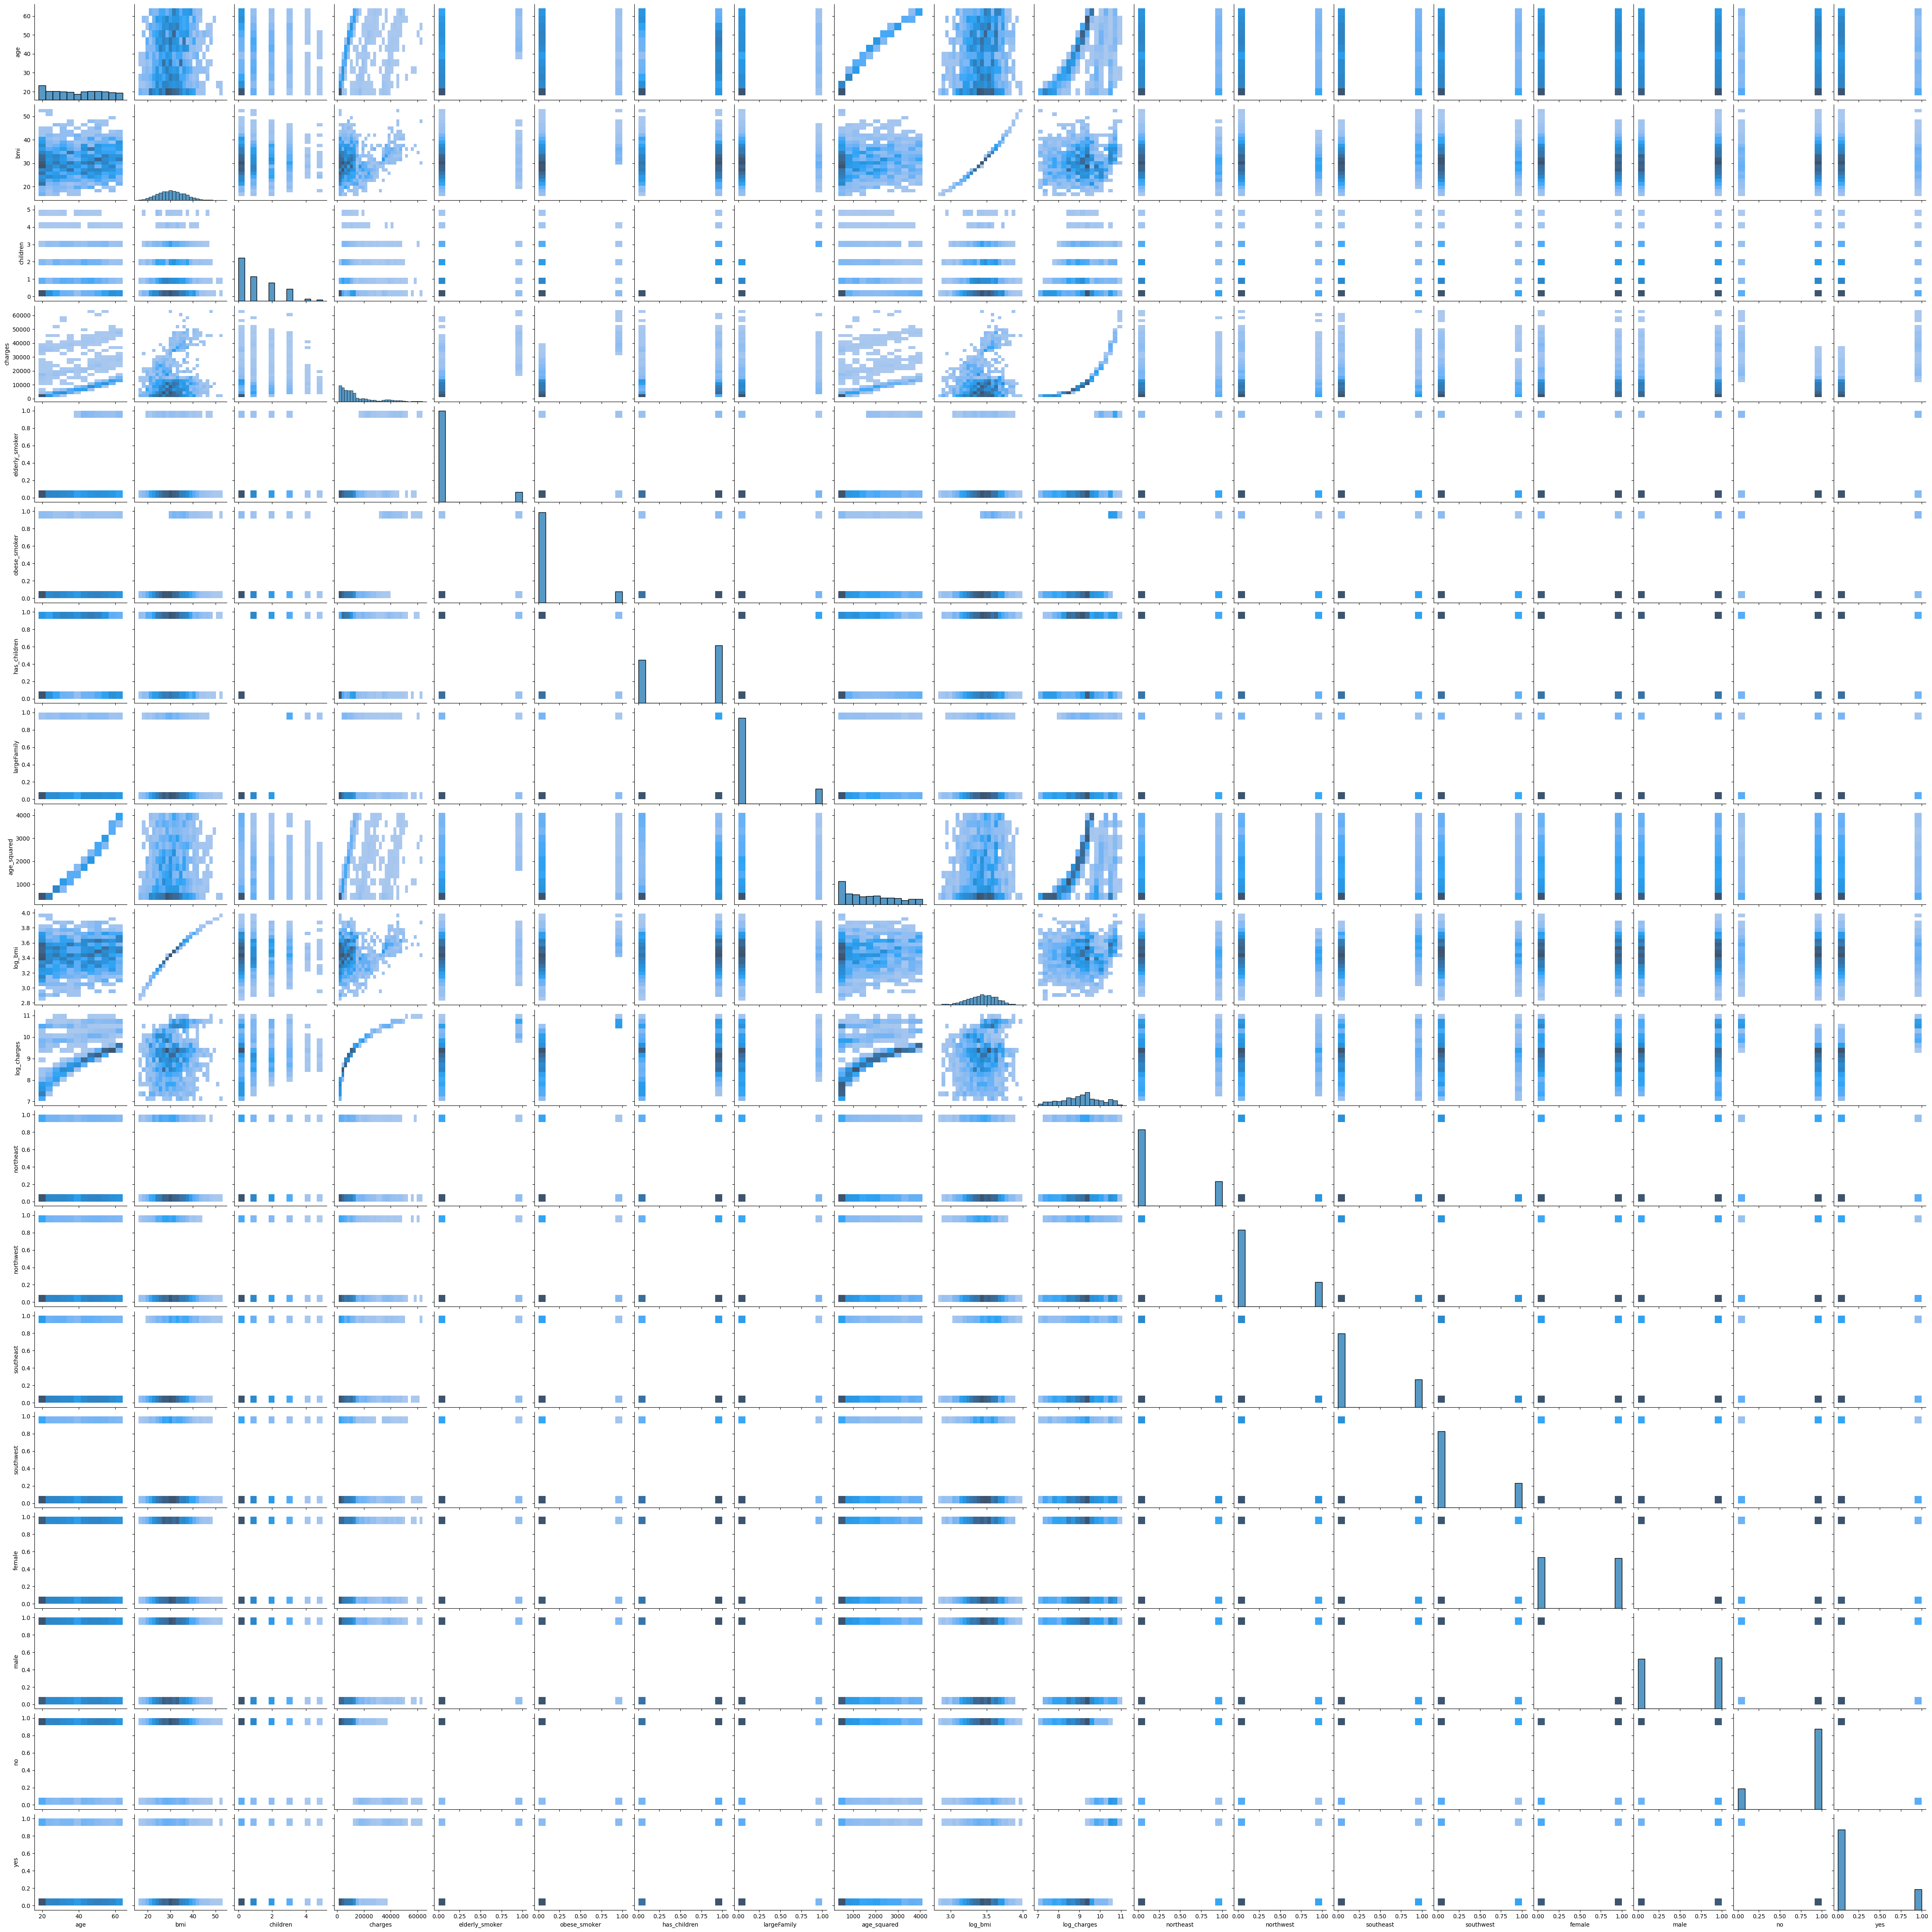

In [25]:
# pairplot video experimentation; this is so large bc of the boolean & numerical features; not super important in the grand scheme of things
sns.pairplot(data, kind='hist')

- detecting numerical features
- histograms on the diagonals; scatter plots everywhere else; can be changed
- use hue for categorical features
- boolean types are treated as numeric
- can specify which exact variables you want to see & which axis they're on 

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)


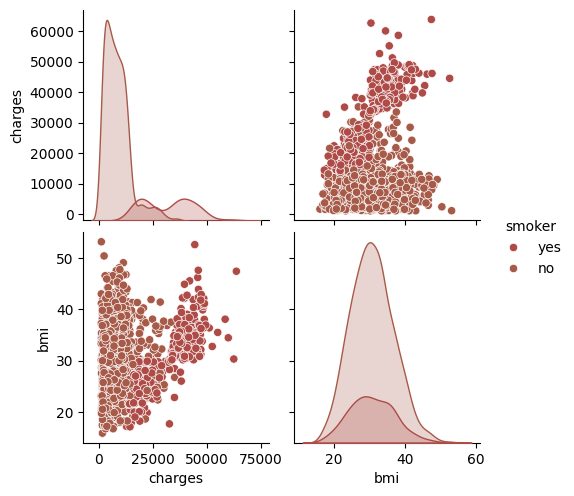

In [26]:
sns.pairplot(data, hue='smoker', palette=palette, vars=['charges', 'bmi'])

/tmp/ipython-input-1108482901.py:2: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.kdeplot(data, x='age', hue='smoker', palette=palette)


<Axes: xlabel='age', ylabel='Density'>

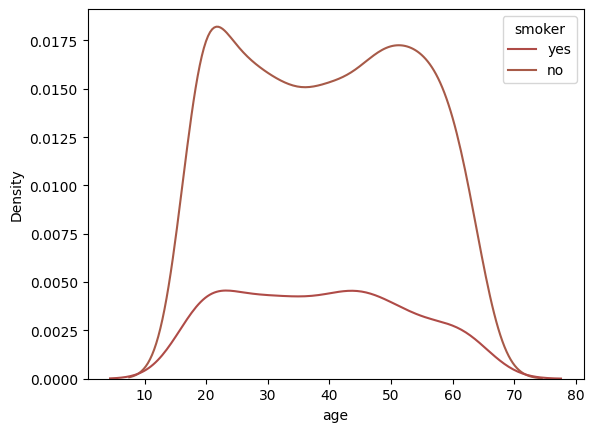

In [27]:
# to understand a misconception
sns.kdeplot(data, x='age', hue='smoker', palette=palette)

learned quite a lot from that; despite the normal-looking curve for bmi, the results showed heavy skew for overweight & obese individuals

/tmp/ipython-input-1573786000.py:1: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.boxplot(y='charges', x='sex', hue='bmi_category', data=data, palette=palette)


<Axes: xlabel='sex', ylabel='charges'>

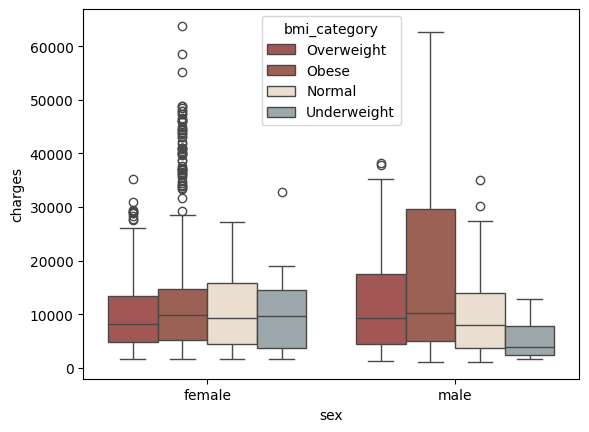

In [28]:
sns.boxplot(y='charges', x='sex', hue='bmi_category', data=data, palette=palette)

In [29]:
data.head()

,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category,charges_category,...,log_bmi,log_charges,northeast,northwest,southeast,southwest,female,male,no,yes
0,19,female,27.900,0,yes,southwest,16884.92400,18-25,Overweight,"$10,001-20,000",...,3.363842,9.734236,False,False,False,True,True,False,False,True
1,18,male,33.770,1,no,southeast,1725.55230,18-25,Obese,"$0-10,000",...,3.548755,7.453882,False,False,True,False,False,True,True,False
2,28,male,33.000,3,no,southeast,4449.46200,26-35,Obese,"$0-10,000",...,3.526361,8.400763,False,False,True,False,False,True,True,False
3,33,male,22.705,0,no,northwest,21984.47061,26-35,Normal,"$20,001-30,000",...,3.165686,9.998137,False,True,False,False,False,True,True,False
4,32,male,28.880,0,no,northwest,3866.85520,26-35,Overweight,"$0-10,000",...,3.397189,8.260455,False,True,False,False,False,True,True,False


In [30]:
# let's create a contingency table to see sex & bmi broken down
crosstab01 = pd.crosstab(data['sex'], data['bmi_category'])
crosstab01

bmi_category,Normal,Obese,Overweight,Underweight
sex,,,,
female,118,334,197,13
male,108,370,189,8


<Axes: xlabel='sex'>

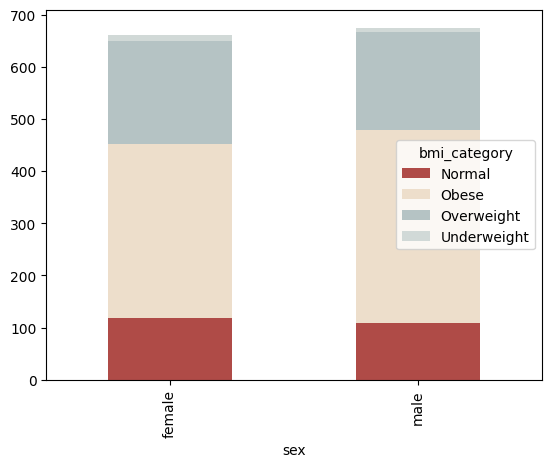

In [31]:
# visualization of above
crosstab01.plot(kind='bar', stacked = True, colormap=customCmap)

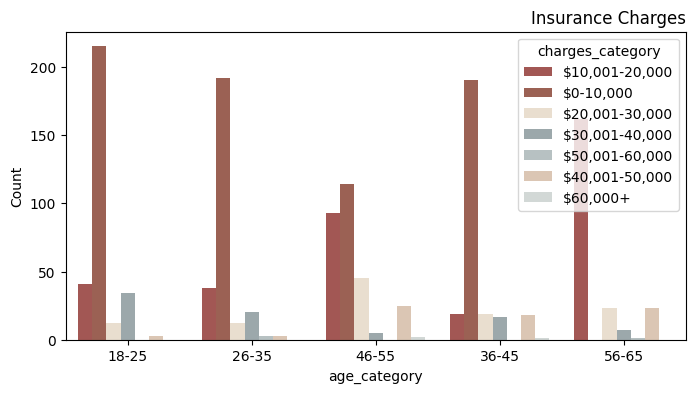

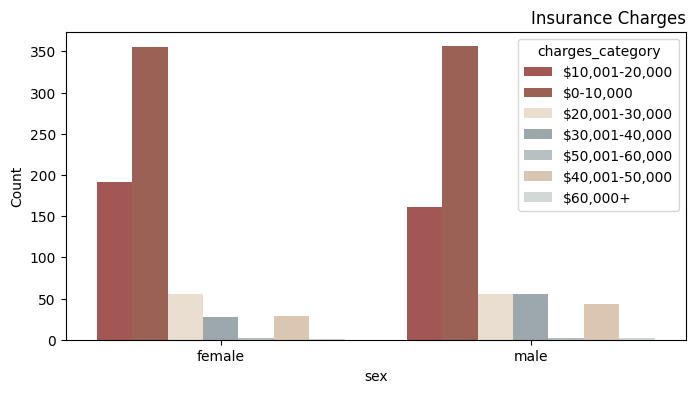

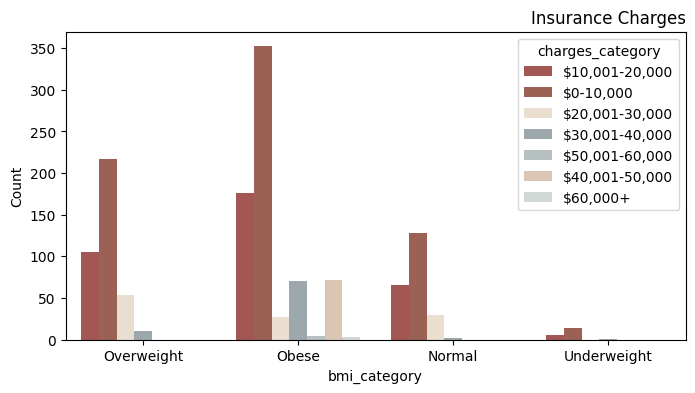

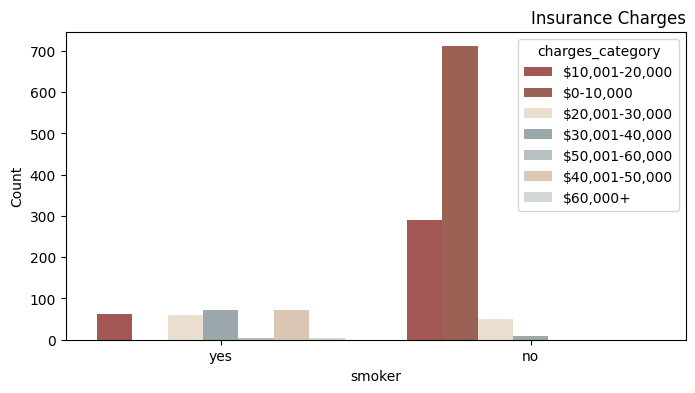

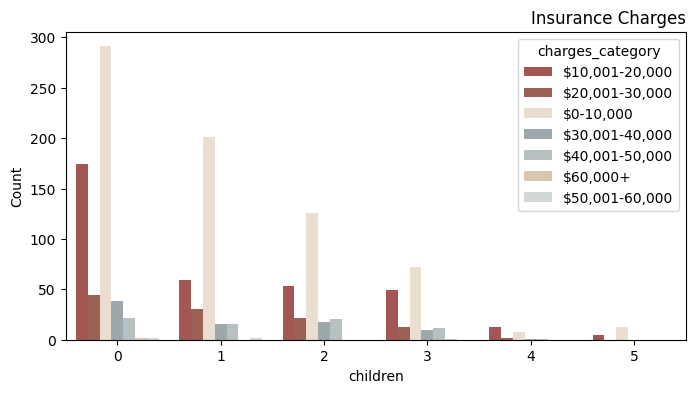

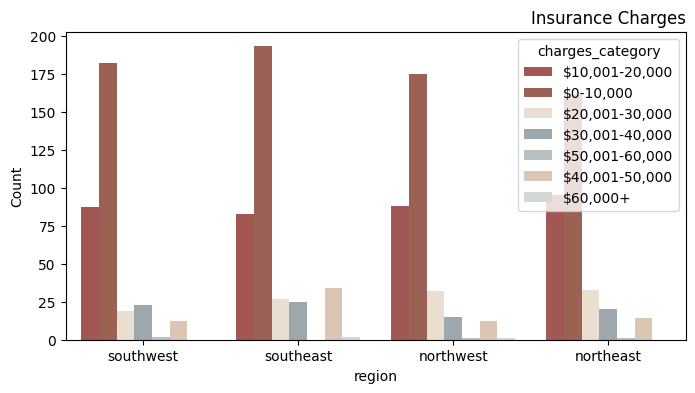

In [32]:
# checking feature importance (i think??); seeing if i can see any distinct noticeable patterns
columns = ['age_category', 'sex', 'bmi_category', 'smoker', 'children', 'region']

for col in columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='charges_category', data=data, palette=palette)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Insurance Charges', loc='right')
    plt.show()

<Axes: xlabel='charges_category'>

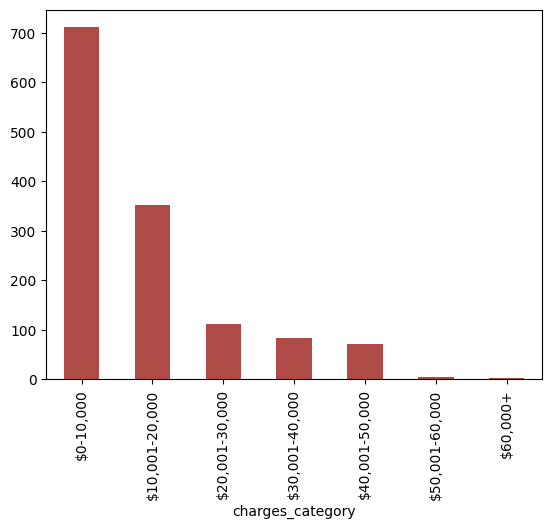

In [33]:
# interesting but knew from sql queries as well as really only helpful for visualizations & classification problems
data['charges_category'].value_counts().plot(kind='bar', colormap=customCmap)

In [34]:
# SO SKEWED
data['charges_category'].value_counts()

,count
charges_category,
"$0-10,000",711
"$10,001-20,000",353
"$20,001-30,000",111
"$30,001-40,000",83
"$40,001-50,000",72
"$50,001-60,000",4
"$60,000+",3


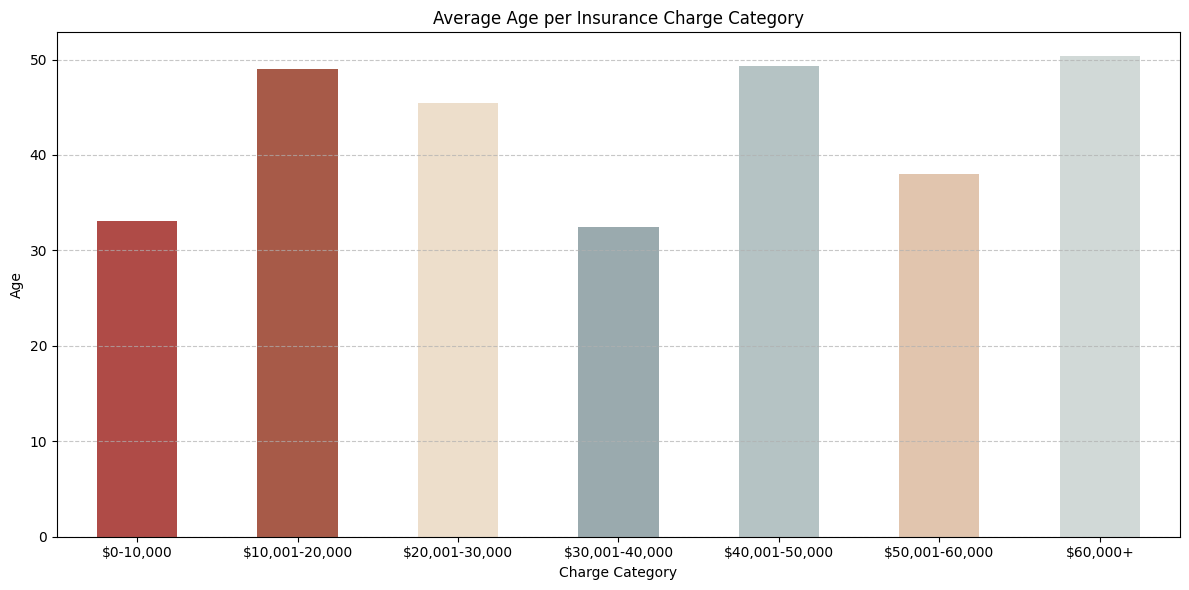

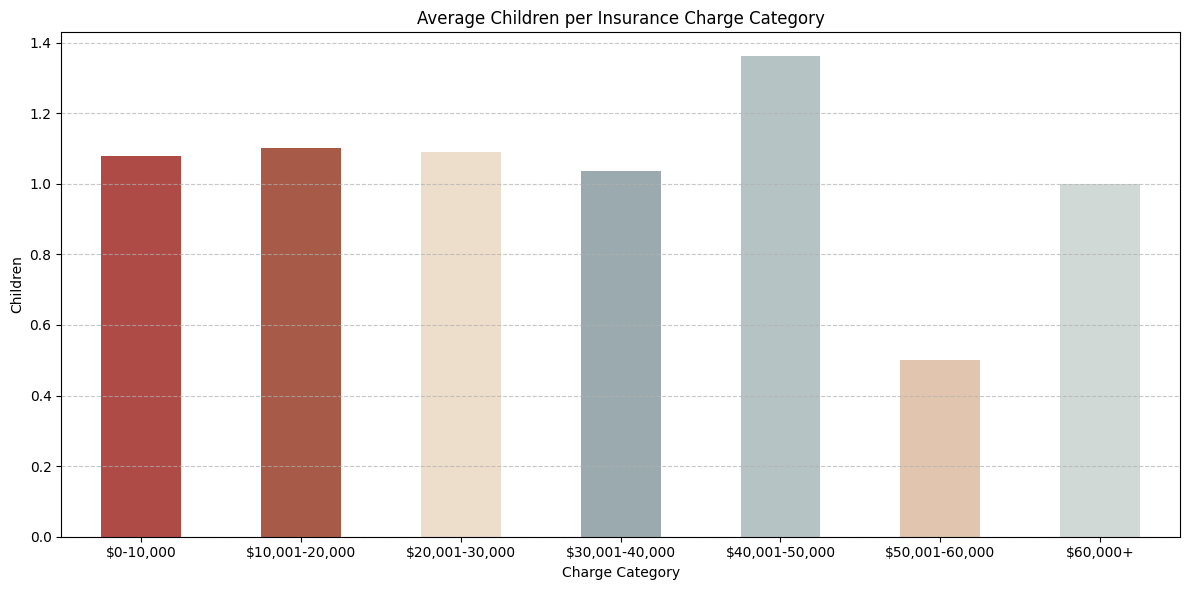

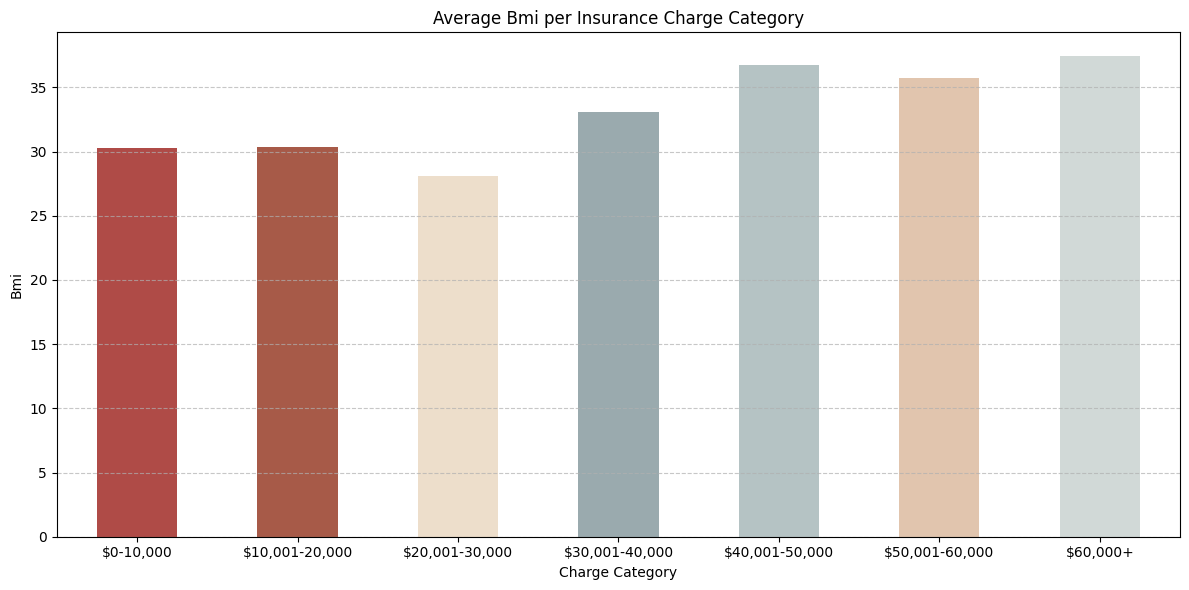

In [35]:
# finding average features for each charge category
numeric_columns = ['age', 'children', 'bmi']

for col in numeric_columns:
    mean_values = data.groupby('charges_category')[col].mean()
    plt.figure(figsize=(12, 6))
    mean_values.plot(kind='bar', color=customCmap.colors)
    plt.title(f'Average {col.capitalize()} per Insurance Charge Category')
    plt.xlabel('Charge Category')
    plt.xticks(rotation=0)
    plt.ylabel(col.capitalize())
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

MODELING

In [36]:
modeling_data = data.drop(['sex', 'smoker', 'region', 'charges_category', 'age_category', 'bmi_category', 'children', 'age', 'bmi', 'charges'], axis=1)
modeling_data.head()

,elderly_smoker,obese_smoker,has_children,largeFamily,age_squared,log_bmi,log_charges,northeast,northwest,southeast,southwest,female,male,no,yes
0,0,0,0,0,361,3.363842,9.734236,False,False,False,True,True,False,False,True
1,0,0,1,0,324,3.548755,7.453882,False,False,True,False,False,True,True,False
2,0,0,1,1,784,3.526361,8.400763,False,False,True,False,False,True,True,False
3,0,0,0,0,1089,3.165686,9.998137,False,True,False,False,False,True,True,False
4,0,0,0,0,1024,3.397189,8.260455,False,True,False,False,False,True,True,False


In [37]:
modeling_data.dtypes

,0
elderly_smoker,int64
obese_smoker,int64
has_children,int64
largeFamily,int64
age_squared,int64
log_bmi,float64
log_charges,float64
northeast,bool
northwest,bool
southeast,bool


In [38]:
# seperate binary & continuous features
continuous_features = ['age_squared', 'log_bmi']
binary_features = ['elderly_smoker', 'obese_smoker', 'has_children', 'largeFamily', 
                   'northeast', 'northwest', 'southeast', 'southwest',
                   'female', 'male', 'no', 'yes']

# should make bools or objects that are one hot encoded into ints
for col in binary_features:
    modeling_data[col] = pd.to_numeric(modeling_data[col], errors='coerce').fillna(0).round().clip(0, 1).astype(int)

# feature & target split
x = modeling_data.drop('log_charges', axis=1)
y = modeling_data['log_charges']

# test train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train_cont = x_train[continuous_features]
x_train_bin = x_train[binary_features]

x_test_cont = x_test[continuous_features]
x_test_bin = x_test[binary_features]

x_test_cont_unscaled = x_test[continuous_features].copy()
x_test_bin_clean = x_test[binary_features].copy()

# scale only the continuous
x_scaler = StandardScaler()
x_train_cont = x_scaler.fit_transform(x_train_cont)
x_test_cont = x_scaler.transform(x_test_cont)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# concat cont & bin back
x_train = pd.DataFrame(np.concatenate([x_train_cont, x_train_bin.values], axis=1), columns=continuous_features + binary_features)
x_test = pd.DataFrame(np.concatenate([x_test_cont, x_test_bin.values], axis=1), columns=continuous_features + binary_features)

In [39]:
# Debug check: confirm all binaries are 0 or 1
print(modeling_data[binary_features].dtypes)
for col in binary_features:
    print(f"{col} unique values: {modeling_data[col].unique()}")

elderly_smoker    int64
obese_smoker      int64
has_children      int64
largeFamily       int64
northeast         int64
northwest         int64
southeast         int64
southwest         int64
female            int64
male              int64
no                int64
yes               int64
dtype: object
elderly_smoker unique values: [0 1]
obese_smoker unique values: [0 1]
has_children unique values: [0 1]
largeFamily unique values: [0 1]
northeast unique values: [0 1]
northwest unique values: [0 1]
southeast unique values: [0 1]
southwest unique values: [1 0]
female unique values: [1 0]
male unique values: [0 1]
no unique values: [0 1]
yes unique values: [1 0]


going to compare random forest (regressor) & regression neural network & decision tree (regressor)

In [42]:
# starting with decision tree
mlflow.sklearn.autolog()

with mlflow.start_run():
    dt_model = DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=10, criterion='absolute_error', random_state=42)
    dt_model.fit(x_train, y_train)
    
    # Evaluation metrics are automatically captured
    train_score = dt_model.score(x_train, y_train)
    test_score = dt_model.score(x_test, y_test)

    print(f"Train accuracy: {train_score:.3f}, Test accuracy: {test_score:.3f}")

2026/02/17 07:51:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format."


Train accuracy: 0.808, Test accuracy: 0.866


In [ ]:
y_pred_dt = dt_model.predict(x_test)
y_pred_dt = y_scaler.inverse_transform(y_pred_dt.reshape(-1, 1))
y_pred_dt = np.expm1(y_pred_dt)

y_true_dt = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_true_dt = np.expm1(y_true_dt)

In [ ]:
mse_dt = mean_squared_error(y_true_dt, y_pred_dt)
mae_dt = mean_absolute_error(y_true_dt, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_true_dt, y_pred_dt)

print(f"Decision Tree - Mean Squared Error: {mse_dt:.4f}")
print(f"Decision Tree - Mean Absolute Error: {mae_dt:.4f}")
print(f"Decision Tree - Root Mean Squared Error: {rmse_dt:.4f}")
print(f"Decision Tree - R² Score: {r2_score(y_true_dt, y_pred_dt):.4f}")

In [ ]:
data.describe()

In [ ]:
mean_charges = 13279
mae_pct_dt = mae_dt / mean_charges * 100
rmse_pct_dt = rmse_dt / mean_charges * 100
print(f"MAE is about {mae_pct_dt:.1f}% of the average cost")
print(f"RMSE is about {rmse_pct_dt:.1f}% of the average cost")

In [ ]:
# feature importance for decision forests
importance = dt_model.feature_importances_
x_names = ['elderly_smoker', 'obese_smoker', 'has_children', 'largeFamily',	'age_squared',	'log_bmi',	'northeast',	'northwest',	'southeast',	'southwest',	'female',	'male',	'no',	'yes']
feature_importances = list(zip(x_names, importance))
feature_importances_sorted = sorted(feature_importances, key=lambda x: x[1], reverse=True)
sorted_names, sorted_importance = zip(*feature_importances_sorted)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center', color=palette)
plt.yticks(np.arange(len(sorted_importance)), sorted_names)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Decision Tree Algorithm')
plt.show()

In [ ]:
# adding residual plot
y_pred_dt = np.ravel(y_pred_dt)
y_true_dt = np.ravel(y_true_dt)
residuals = y_true_dt - y_pred_dt

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_dt, y=residuals)
plt.axhline(0, color='pink', linestyle='--')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residual Plot of Decision Tree Algorithm')
plt.show()

In [ ]:
# adding actual vs predicted plot
plt.scatter(y_true_dt, y_pred_dt, alpha = 0.4)
plt.plot([y_true_dt.min(), y_true_dt.max()], [y_true_dt.min(), y_true_dt.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [ ]:
# beginning of error analysis
errors = y_true_dt.flatten() - y_pred_dt.flatten()
abs_errors = np.abs(errors)
pct_errors = (abs_errors / y_true_dt.flatten()) * 100

# create dataframe
error_data_dt = pd.DataFrame({
    'true_value': y_true_dt.flatten(),
    'predicted_value': y_pred_dt.flatten(),
    'error': errors,
    'abs_error': abs_errors,
    'pct_error': pct_errors
})

x_test_features = pd.concat([
    x_test_cont_unscaled.reset_index(drop=True),
    x_test_bin_clean.reset_index(drop=True)
], axis=1)

error_data_dt = pd.concat([
    error_data_dt.reset_index(drop=True),
    x_test_features.reset_index(drop=True)
], axis=1)

In [ ]:
error_data_dt.head()

In [ ]:
error_data_dt.to_csv('errors_dt.csv')

In [ ]:
# most basic error statistics
# any feature from x_test_original is one-hot encoded so statistics on them do not matter; what's important is seeing a correlation or relationship with features being yes or no and error
error_data_dt.describe()

In [ ]:
# missing error statistics
print(f"median error: ${np.median(errors):,.2f}")
print(f"median absolute error: ${np.median(abs_errors):,.2f}")

In [ ]:
# error percentiles
print('=== error percentiles ===')
for percentile in [50, 75, 90, 95, 99]:
    value = np.percentile(abs_errors, percentile)
    print(f'{percentile}th percentile: ${value:,.2f}')

In [ ]:
# check for bias (systematic open/under prediction)
t_stat, p_value = stats.ttest_1samp(errors, 0)

print(f"mean error: ${errors.mean():.2f}")
print(f'as % of average cost: {(errors.mean() / y_true_dt.mean()) * 100:.2f}')

if p_value < 0.05 and abs(errors.mean()) > 100:
    if errors.mean() > 0:
        print(f"\n⚠️ model systematically underpredicts (p={p_value:.4f})")
    else: 
        print(f"\n⚠️ model systematically overpredicts (p={p_value:.4f})")
else:
    print(f"\n✅ no significant systematic bias detected (p={p_value:.4f})")

In [ ]:
# are high-cost cases driving the bias?
print("\n=== errors by Cost Range ===")
error_data_dt['cost_bin'] = pd.cut(error_data_dt['true_value'], 
                               bins=[0, 5000, 10000, 20000, 100000],
                               labels=['<$5k', '$5-10k', '$10-20k', '>$20k'])
print(error_data_dt.groupby('cost_bin')['error'].agg(['mean', 'count']))

In [ ]:
# check this
plt.figure(figsize=(10, 6))
plt.scatter(y_true_dt, errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('True Value ($)')
plt.ylabel('Error (True - Predicted) ($)')
plt.title('Error Pattern: Underprediction Increases with Cost')
plt.show()

In [ ]:
# let's look at this more carefully
print("=== Detailed Error Analysis by Cost Range ===\n")

for range_name in ['<$5k', '$5-10k', '$10-20k', '>$20k']:
    range_data = error_data_dt[error_data_dt['cost_bin'] == range_name]
    
    print(f"\n{range_name}:")
    print(f"  Count: {len(range_data)}")
    print(f"  Mean error: ${range_data['error'].mean():,.2f}")
    print(f"  Median error: ${range_data['error'].median():,.2f}")
    print(f"  Std dev: ${range_data['error'].std():,.2f}")
    print(f"  Max error: ${range_data['error'].max():,.2f}")
    print(f"  Min error: ${range_data['error'].min():,.2f}")
    
    # big errors
    big_errors = range_data[np.abs(range_data['error']) > 5000]
    print(f"  # with error >$5k: {len(big_errors)} ({len(big_errors)/len(range_data)*100:.1f}%)")

In [ ]:
# check this
print("\n=== Outlier Analysis ===")
threshold = 5000

outliers = error_data_dt[np.abs(error_data_dt['error']) > threshold]
print(f"Predictions with error >${threshold}: {len(outliers)} ({len(outliers)/len(error_data_dt)*100:.1f}%)")
print(f"These {len(outliers)} outliers account for ${outliers['abs_error'].sum():,.0f} of total error")
print(f"That's {outliers['abs_error'].sum() / error_data_dt['abs_error'].sum() * 100:.1f}% of total error")

print("\nWhat do outliers look like?")
print(outliers[['true_value', 'predicted_value', 'error']].describe())

In [ ]:
print("\n=== WHO ARE THE OUTLIERS? ===\n")

# get the 24 outliers
outliers = error_data_dt[np.abs(error_data_dt['error']) > 5000]

print(f"Number of outliers: {len(outliers)}")

print("\nOutlier Characteristics:")

# Smoker status (column is 'yes' for smoker)
if 'yes' in outliers.columns:
    print(f"\nSmoker percentage:")
    print(f"  Outliers: {outliers['yes'].mean()*100:.1f}%")
    print(f"  Overall: {error_data_dt['yes'].mean()*100:.1f}%")

# BMI (it's log-transformed, so need to reverse it)
if 'log_bmi' in outliers.columns:
    print(f"\nAverage log(BMI):")
    print(f"  Outliers: {outliers['log_bmi'].mean():.2f}")
    print(f"  Overall: {error_data_dt['log_bmi'].mean():.2f}")
    
    # Convert back to actual BMI
    outlier_bmi = np.exp(outliers['log_bmi'].mean())
    overall_bmi = np.exp(error_data_dt['log_bmi'].mean())
    print(f"\nActual BMI (converted):")
    print(f"  Outliers: {outlier_bmi:.1f}")
    print(f"  Overall: {overall_bmi:.1f}")

# Age (it's squared, so need to take sqrt)
if 'age_squared' in outliers.columns:
    outlier_age = np.sqrt(outliers['age_squared'].mean())
    overall_age = np.sqrt(error_data_dt['age_squared'].mean())
    print(f"\nAverage Age (from age_squared):")
    print(f"  Outliers: {outlier_age:.1f}")
    print(f"  Overall: {overall_age:.1f}")

# Your engineered features
if 'obese_smoker' in outliers.columns:
    print(f"\nObese Smoker percentage:")
    print(f"  Outliers: {outliers['obese_smoker'].mean()*100:.1f}%")
    print(f"  Overall: {error_data_dt['obese_smoker'].mean()*100:.1f}%")

if 'elderly_smoker' in outliers.columns:
    print(f"\nElderly Smoker percentage:")
    print(f"  Outliers: {outliers['elderly_smoker'].mean()*100:.1f}%")
    print(f"  Overall: {error_data_dt['elderly_smoker'].mean()*100:.1f}%")

# Region distribution
print(f"\nRegion distribution:")
for region in ['northeast', 'northwest', 'southeast', 'southwest']:
    if region in outliers.columns:
        outlier_pct = outliers[region].mean() * 100
        overall_pct = error_data_dt[region].mean() * 100
        print(f"  {region.capitalize()}: Outliers {outlier_pct:.1f}% vs Overall {overall_pct:.1f}%")

print("\n=== HYPOTHESIS CHECK ===")
if 'obese_smoker' in outliers.columns:
    obese_smokers = outliers[outliers['obese_smoker'] == 1]
    print(f"Outliers that are obese smokers: {len(obese_smokers)} / {len(outliers)} ({len(obese_smokers)/len(outliers)*100:.1f}%)")

if 'elderly_smoker' in outliers.columns:
    elderly_smokers = outliers[outliers['elderly_smoker'] == 1]
    print(f"Outliers that are elderly smokers: {len(elderly_smokers)} / {len(outliers)} ({len(elderly_smokers)/len(outliers)*100:.1f}%)")

# Combined high risk
if 'obese_smoker' in outliers.columns and 'elderly_smoker' in outliers.columns:
    high_risk = outliers[(outliers['obese_smoker'] == 1) | (outliers['elderly_smoker'] == 1)]
    print(f"Outliers that are EITHER obese smokers OR elderly smokers: {len(high_risk)} / {len(outliers)} ({len(high_risk)/len(outliers)*100:.1f}%)")

In [ ]:
print("\n=== WHAT ARE THE OTHER 75% OF OUTLIERS? ===\n")

# Get outliers that are NOT high-risk
outliers = error_data_dt[np.abs(error_data_dt['error']) > 5000]
non_high_risk_outliers = outliers[
    (outliers['obese_smoker'] == 0) & 
    (outliers['elderly_smoker'] == 0)
]

print(f"Non-high-risk outliers: {len(non_high_risk_outliers)} / {len(outliers)}")

print("\nTheir characteristics:")
print(f"Average age: {np.sqrt(non_high_risk_outliers['age_squared'].mean()):.1f}")
print(f"Average BMI: {np.exp(non_high_risk_outliers['log_bmi'].mean()):.1f}")
print(f"Smoker %: {non_high_risk_outliers['yes'].mean()*100:.1f}%")
print(f"Has children %: {non_high_risk_outliers['has_children'].mean()*100:.1f}%")

print("\nRegion breakdown:")
for region in ['northeast', 'northwest', 'southeast', 'southwest']:
    pct = non_high_risk_outliers[region].mean() * 100
    print(f"  {region.capitalize()}: {pct:.1f}%")

print("\n=== Look at specific cases ===")
print(non_high_risk_outliers[['true_value', 'predicted_value', 'error', 
                               'yes', 'log_bmi', 'age_squared']].head(10))

In [ ]:
# Investigate Northeast specifically
print("\n=== NORTHEAST DEEP DIVE ===")

northeast_data = error_data_dt[error_data_dt['northeast'] == 1]
other_regions = error_data_dt[error_data_dt['northeast'] == 0]

print(f"\nNortheast error statistics:")
print(f"  Mean error: ${northeast_data['error'].mean():,.2f}")
print(f"  Median error: ${northeast_data['error'].median():,.2f}")
print(f"  MAE: ${northeast_data['abs_error'].mean():,.2f}")
print(f"  Outlier rate: {(northeast_data['abs_error'] > 5000).sum() / len(northeast_data) * 100:.1f}%")

print(f"\nOther regions error statistics:")
print(f"  Mean error: ${other_regions['error'].mean():,.2f}")
print(f"  Median error: ${other_regions['error'].median():,.2f}")
print(f"  MAE: ${other_regions['abs_error'].mean():,.2f}")
print(f"  Outlier rate: {(other_regions['abs_error'] > 5000).sum() / len(other_regions) * 100:.1f}%")

In [ ]:
print("\n=== DECISION TREE - HIGH-RISK GROUPS ===")

if 'obese_smoker' in error_data_dt.columns:
    obese_smokers_dt = error_data_dt[error_data_dt['obese_smoker'] == 1]
    others_dt = error_data_dt[error_data_dt['obese_smoker'] == 0]
    
    print(f"\nObese Smokers:")
    print(f"  Count: {len(obese_smokers_dt)}")
    print(f"  MAE: ${obese_smokers_dt['abs_error'].mean():,.2f}")
    print(f"  Others MAE: ${others_dt['abs_error'].mean():,.2f}")
    print(f"  Difference: {(obese_smokers_dt['abs_error'].mean() / others_dt['abs_error'].mean() - 1) * 100:.1f}% worse")
    print(f"  Outliers (>$5k): {(obese_smokers_dt['abs_error'] > 5000).sum()}/{len(obese_smokers_dt)} ({(obese_smokers_dt['abs_error'] > 5000).sum()/len(obese_smokers_dt)*100:.1f}%)")
    print(f"  Mean error: ${obese_smokers_dt['error'].mean():,.2f}")

RANDOM FOREST

In [ ]:
# adding hyperparam tuning to random forest 
n_estimators = [50, 100, 200, 300] # num of trees in random forest
max_features = ['auto', 'sqrt', 'log2'] # num of features to consider @ every split
max_depth = [4, 8, 12, None] # max num of levels in tree
min_samples_split = [2, 5, 10] # min num of samples to split a node
min_samples_leaf = [1, 2, 4] # min num of samples to split each leaf node
bootstrap = [True] # method of selecting samples for tree training

In [ ]:
param_grid = {'n_estimators': n_estimators,
                            'max_features': max_features,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'bootstrap': bootstrap}

In [ ]:
rf_model = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, cv = 3, verbose = 2, n_jobs = 1, n_iter = 50, scoring = 'neg_mean_absolute_error', random_state = 42)
rf_random.fit(x_train, y_train)

In [ ]:
best_rf_model = rf_random.best_estimator_

In [ ]:
y_pred_rf = best_rf_model.predict(x_test)
y_pred_rf = y_scaler.inverse_transform(y_pred_rf.reshape(-1, 1))
y_pred_rf = np.expm1(y_pred_rf)

y_true_rf = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_true_rf = np.expm1(y_true_rf)

In [ ]:
mse_rf = mean_squared_error(y_true_rf, y_pred_rf)
mae_rf = mean_absolute_error(y_true_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_true_rf, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf:.4f}")
print(f"Random Forest - Mean Absolute Error: {mae_rf:.4f}")
print(f"Random Forest - Root Mean Squared Error: {rmse_rf:.4f}")
print(f"Random Forest - R² Score: {r2_score(y_true_rf, y_pred_rf):.4f}")

In [ ]:
mae_pct_rf = mae_rf / mean_charges * 100
rmse_pct_rf = rmse_rf / mean_charges * 100
print(f"MAE is about {mae_pct_rf:.1f}% of the average cost")
print(f"RMSE is about {rmse_pct_rf:.1f}% of the average cost")

In [ ]:
# feature importance for random forests
importance = best_rf_model.feature_importances_
x_names = ['elderly_smoker', 'obese_smoker', 'has_children', 'largeFamily',	'age_squared',	'log_bmi',	'northeast',	'northwest',	'southeast',	'southwest',	'female',	'male',	'no',	'yes']
feature_importances = list(zip(x_names, importance))
feature_importances_sorted = sorted(feature_importances, key=lambda x: x[1], reverse=True)
sorted_names, sorted_importance = zip(*feature_importances_sorted)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center', color=palette)
plt.yticks(np.arange(len(sorted_importance)), sorted_names)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Algorithm')
plt.show()

In [ ]:
# adding residual plots
y_pred_rf = np.ravel(y_pred_rf)
y_true_rf = np.ravel(y_true_rf)
residuals = y_true_rf - y_pred_rf

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='pink', linestyle='--') 
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residual Plot of Random Forest Algorithm')
plt.show()

In [ ]:
# adding actual vs predicted plot
plt.scatter(y_true_rf, y_pred_rf, alpha = 0.4)
plt.plot([y_true_rf.min(), y_true_rf.max()], [y_true_rf.min(), y_true_rf.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [ ]:
# beginning of error analysis
errors = y_true_rf.flatten() - y_pred_rf.flatten()
abs_errors = np.abs(errors)
pct_errors = (abs_errors / y_true_rf.flatten()) * 100

# create dataframe
error_data_rf = pd.DataFrame({
    'true_value': y_true_rf.flatten(),
    'predicted_value': y_pred_rf.flatten(),
    'error': errors,
    'abs_error': abs_errors,
    'pct_error': pct_errors
})

x_test_features = pd.concat([
    x_test_cont_unscaled.reset_index(drop=True),
    x_test_bin_clean.reset_index(drop=True)
], axis=1)

error_data_rf = pd.concat([
    error_data_rf.reset_index(drop=True),
    x_test_features.reset_index(drop=True)
], axis=1)

In [ ]:
error_data_rf.head()

In [ ]:
error_data_rf.to_csv('errors_rf.csv')

In [ ]:
error_data_rf.describe()

In [ ]:
# missing error statistics
print(f"median error: ${np.median(errors):,.2f}")
print(f"median absolute error: ${np.median(abs_errors):,.2f}")

In [ ]:
# error percentiles
print('=== error percentiles ===')
for percentile in [50, 75, 90, 95, 99]:
    value = np.percentile(abs_errors, percentile)
    print(f'{percentile}th percentile: ${value:,.2f}')

In [ ]:
# check for bias (systematic open/under prediction)
t_stat, p_value = stats.ttest_1samp(errors, 0)

print(f"mean error: ${errors.mean():.2f}")
print(f'as % of average cost: {(errors.mean() / y_true_dt.mean()) * 100:.2f}')

if p_value < 0.05 and abs(errors.mean()) > 100:
    if errors.mean() > 0:
        print(f"\n⚠️ model systematically underpredicts (p={p_value:.4f})")
    else: 
        print(f"\n⚠️ model systematically overpredicts (p={p_value:.4f})")
else:
    print(f"\n✅ no significant systematic bias detected (p={p_value:.4f})")

In [ ]:
print("\n=== ERRORS BY COST RANGE ===")
error_data_rf['cost_bin'] = pd.cut(error_data_rf['true_value'], 
                                     bins=[0, 5000, 10000, 20000, 100000],
                                     labels=['<$5k', '$5-10k', '$10-20k', '>$20k'])

for range_name in ['<$5k', '$5-10k', '$10-20k', '>$20k']:
    range_data = error_data_rf[error_data_rf['cost_bin'] == range_name]
    print(f"\n{range_name}:")
    print(f"  Count: {len(range_data)}")
    print(f"  Mean error: ${range_data['error'].mean():,.2f}")
    print(f"  Median error: ${range_data['error'].median():,.2f}")
    print(f"  # with error >$5k: {(range_data['abs_error'] > 5000).sum()} ({(range_data['abs_error'] > 5000).sum()/len(range_data)*100:.1f}%)")

In [ ]:
print("\n=== OUTLIER ANALYSIS ===")
outliers_rf = error_data_rf[error_data_rf['abs_error'] > 5000]
print(f"Outliers (>$5k error): {len(outliers_rf)} ({len(outliers_rf)/len(error_data_rf)*100:.1f}%)")
print(f"These account for {outliers_rf['abs_error'].sum() / error_data_rf['abs_error'].sum() * 100:.1f}% of total error")

In [ ]:
print("\n=== REGIONAL BREAKDOWN ===")
for region in ['northeast', 'northwest', 'southeast', 'southwest']:
    region_data = error_data_rf[error_data_rf[region] == 1]
    other_data = error_data_rf[error_data_rf[region] == 0]
    
    print(f"\n{region.upper()}:")
    print(f"  Mean error: ${region_data['error'].mean():,.2f} (others: ${other_data['error'].mean():,.2f})")
    print(f"  MAE: ${region_data['abs_error'].mean():,.2f} (others: ${other_data['abs_error'].mean():,.2f})")
    print(f"  Outlier rate: {(region_data['abs_error'] > 5000).sum()/len(region_data)*100:.1f}% (others: {(other_data['abs_error'] > 5000).sum()/len(other_data)*100:.1f}%)")

In [ ]:
print("\n=== HIGH-RISK GROUPS ===")
if 'obese_smoker' in error_data_rf.columns:
    obese_smokers = error_data_rf[error_data_rf['obese_smoker'] == 1]
    others = error_data_rf[error_data_rf['obese_smoker'] == 0]
    print(f"\nObese Smokers:")
    print(f"  MAE: ${obese_smokers['abs_error'].mean():,.2f} (others: ${others['abs_error'].mean():,.2f})")
    print(f"  Outliers: {(obese_smokers['abs_error'] > 5000).sum()}/{len(obese_smokers)} ({(obese_smokers['abs_error'] > 5000).sum()/len(obese_smokers)*100:.1f}%)")

NEURAL NETWORK

In [ ]:
# simple nn arch
def build_nn(n_features):
    model = keras.Sequential([
        Input(shape=(n_features,)),
        tf.keras.layers.Dense(64, activation = 'relu', ),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    return model

In [ ]:
nn_model = KerasRegressor(model=build_nn, epochs=20, batch_size=16, verbose=0, model__n_features = x_train.shape[1])

In [ ]:
nn_model.fit(x_train, y_train)

In [ ]:
y_pred_nn = nn_model.predict(x_test)
y_pred_nn = y_scaler.inverse_transform(y_pred_nn.reshape(-1, 1))
y_pred_nn = np.expm1(y_pred_nn)

y_true_nn = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_true_nn = np.expm1(y_true_nn)

In [ ]:
mse_nn = mean_squared_error(y_true_nn, y_pred_nn)
mae_nn = mean_absolute_error(y_true_nn, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_true_nn, y_pred_nn)

print(f"Neural Network - Mean Squared Error: {mse_nn:.4f}")
print(f"Neural Network - Mean Absolute Error: {mae_nn:.4f}")
print(f"Neural Network - Root Mean Squared Error: {rmse_nn:.4f}")
print(f"Neural Network - R² Score: {r2_score(y_true_nn, y_pred_nn):.4f}") # for PFI, this is baseline score; where no score has been permuted

In [ ]:
mae_pct_nn = mae_nn / mean_charges * 100
rmse_pct_nn = rmse_nn / mean_charges * 100
print(f"MAE is about {mae_pct_nn:.1f}% of the average cost")
print(f"RMSE is about {rmse_pct_nn:.1f}% of the average cost")

In [ ]:
# permutation feature importance for neural network
r = permutation_importance(nn_model, x_test, y_test, n_repeats = 10, random_state = 42)

sorted_idx = r.importances_mean.argsort()
plt.barh(np.array(x_names)[sorted_idx], r.importances_mean[sorted_idx], color = palette)
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Neural Network)")
plt.show()

In [ ]:
# adding residual plots
y_pred_nn = np.ravel(y_pred_nn)
y_true_nn = np.ravel(y_true_nn)
residuals = y_true_nn - y_pred_nn

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_nn, y=residuals)
plt.axhline(0, color='pink', linestyle='--') 
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residual Plot of Neural Network Algorithm')
plt.show()

In [ ]:
# adding actual vs predicted plot
plt.scatter(y_true_nn, y_pred_nn, alpha = 0.4)
plt.plot([y_true_nn.min(), y_true_nn.max()], [y_true_nn.min(), y_true_nn.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [ ]:
# adding kfold cross val
kfold = KFold(n_splits = 5, shuffle=True, random_state = 42)
cv_scores = cross_val_score(nn_model, x_train, y_train, cv = kfold, scoring = 'r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

In [ ]:
# beginning of error analysis
errors = y_true_nn.flatten() - y_pred_nn.flatten()
abs_errors = np.abs(errors)
pct_errors = (abs_errors / y_true_nn.flatten()) * 100

# create dataframe
error_data_nn = pd.DataFrame({
    'true_value': y_true_nn.flatten(),
    'predicted_value': y_pred_nn.flatten(),
    'error': errors,
    'abs_error': abs_errors,
    'pct_error': pct_errors
})

x_test_features = pd.concat([
    x_test_cont_unscaled.reset_index(drop=True),
    x_test_bin_clean.reset_index(drop=True)
], axis=1)

error_data_nn = pd.concat([
    error_data_nn.reset_index(drop=True),
    x_test_features.reset_index(drop=True)
], axis=1)

In [ ]:
error_data_nn.head()

In [ ]:
error_data_nn.to_csv('errors_nn.csv')

In [ ]:
error_data_nn.describe()

In [ ]:
# missing error statistics
print(f"median error: ${np.median(errors):,.2f}")
print(f"median absolute error: ${np.median(abs_errors):,.2f}")

In [ ]:
# error percentiles
print('=== error percentiles ===')
for percentile in [50, 75, 90, 95, 99]:
    value = np.percentile(abs_errors, percentile)
    print(f'{percentile}th percentile: ${value:,.2f}')

In [ ]:
# check for bias (systematic open/under prediction)
t_stat, p_value = stats.ttest_1samp(errors, 0)

print(f"mean error: ${errors.mean():.2f}")
print(f'as % of average cost: {(errors.mean() / y_true_dt.mean()) * 100:.2f}')

if p_value < 0.05 and abs(errors.mean()) > 100:
    if errors.mean() > 0:
        print(f"\n⚠️ model systematically underpredicts (p={p_value:.4f})")
    else: 
        print(f"\n⚠️ model systematically overpredicts (p={p_value:.4f})")
else:
    print(f"\n✅ no significant systematic bias detected (p={p_value:.4f})")

In [ ]:
# Step 1: Error by Cost Range
print("=== ERRORS BY COST RANGE ===")
error_data_nn['cost_bin'] = pd.cut(error_data_nn['true_value'], 
                                     bins=[0, 5000, 10000, 20000, 100000],
                                     labels=['<$5k', '$5-10k', '$10-20k', '>$20k'])

for range_name in ['<$5k', '$5-10k', '$10-20k', '>$20k']:
    range_data = error_data_nn[error_data_nn['cost_bin'] == range_name]
    print(f"\n{range_name}:")
    print(f"  Count: {len(range_data)}")
    print(f"  Mean error: ${range_data['error'].mean():,.2f}")
    print(f"  Median error: ${range_data['error'].median():,.2f}")
    print(f"  # with error >$5k: {(range_data['abs_error'] > 5000).sum()} ({(range_data['abs_error'] > 5000).sum()/len(range_data)*100:.1f}%)")

# Step 2: Outlier Analysis
print("\n=== OUTLIER ANALYSIS ===")
outliers_nn = error_data_nn[error_data_nn['abs_error'] > 5000]
print(f"Outliers (>$5k error): {len(outliers_nn)} ({len(outliers_nn)/len(error_data_nn)*100:.1f}%)")
print(f"These account for {outliers_nn['abs_error'].sum() / error_data_nn['abs_error'].sum() * 100:.1f}% of total error")

# Step 3: Regional Breakdown
print("\n=== REGIONAL BREAKDOWN ===")
for region in ['northeast', 'northwest', 'southeast', 'southwest']:
    region_data = error_data_nn[error_data_nn[region] == 1]
    other_data = error_data_nn[error_data_nn[region] == 0]
    
    print(f"\n{region.upper()}:")
    print(f"  Mean error: ${region_data['error'].mean():,.2f} (others: ${other_data['error'].mean():,.2f})")
    print(f"  MAE: ${region_data['abs_error'].mean():,.2f} (others: ${other_data['abs_error'].mean():,.2f})")
    print(f"  Outlier rate: {(region_data['abs_error'] > 5000).sum()/len(region_data)*100:.1f}% (others: {(other_data['abs_error'] > 5000).sum()/len(other_data)*100:.1f}%)")

# Step 4: High-Risk Groups
print("\n=== HIGH-RISK GROUPS ===")
if 'obese_smoker' in error_data_nn.columns:
    obese_smokers = error_data_nn[error_data_nn['obese_smoker'] == 1]
    others = error_data_nn[error_data_nn['obese_smoker'] == 0]
    print(f"\nObese Smokers:")
    print(f"  MAE: ${obese_smokers['abs_error'].mean():,.2f} (others: ${others['abs_error'].mean():,.2f})")
    print(f"  Outliers: {(obese_smokers['abs_error'] > 5000).sum()}/{len(obese_smokers)} ({(obese_smokers['abs_error'] > 5000).sum()/len(obese_smokers)*100:.1f}%)")

In [ ]:
import pickle

with open('decision_tree_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)
    
print('decision_tree_model.pkl saved')

In [ ]:
with open('x_scaler.pkl', 'wb') as f:
    pickle.dump(x_scaler, f)

print('x_scaler.pkl saved')

In [ ]:
with open('y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)
    
print('y_scaler.pkl saved')

In [ ]:
feature_names = x_train.columns.tolist()

with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
    
print("feature_names.pkl saved")
print(f"\nFeature names: {feature_names}")

In [ ]:
import os

files_to_check = [
    'decision_tree_model.pkl',
    'x_scaler.pkl',
    'y_scaler.pkl',
    'feature_names.pkl'
]

print("\n=== checking saved files ===")
for file in files_to_check:
    if os.path.exists(file):
        size = os.path.getsize(file) / 1024  # size in KB
        print(f"✅ {file} - {size:.2f} KB")
    else:
        print(f"❌ {file} - NOT FOUND")


print("\n=== Testing if files load correctly ===")

try:
    with open('decision_tree_model.pkl', 'rb') as f:
        test_model = pickle.load(f)
    print("✅ Model loads successfully")
    
    with open('x_scaler.pkl', 'rb') as f:
        x_test_scaler = pickle.load(f)
    print("✅ x_scaler loads successfully")
    
    with open('y_scaler.pkl', 'rb') as f:
        y_test_scaler = pickle.load(f)
    print("✅ y_scaler loads successfully")
    
    with open('feature_names.pkl', 'rb') as f:
        test_features = pickle.load(f)
    print(f"✅ Feature names load successfully: {len(test_features)} features")
    
    print("\n🎉 All files ready for deployment!")
    
except Exception as e:
    print(f"❌ Error loading files: {e}")

In [ ]:
categorical = pd.read_csv('data_categorical.csv')

In [ ]:
categorical.head()